<a href="https://colab.research.google.com/github/lln-cid20/prog-ciencia-dados/blob/master/TrabalhoConjunto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Apresentação**

**Resumo**

Este trabalho, realizado como atividade final da disciplina de Programação para Ciência de Dados, do curso de Pós-graduação em Ciência de Dados 2020/2021, apresenta os resultados da análise sobre uma base de dados de tweets, procurando identificar as diversas perguntas feitas em relação à COVID-19, bem como classificar as perguntas conforme os tipos a seguir: sintomas, tratamento, entidades e pessoas.

**Autores**
*   Lelson Lopes Nascimento
*   Levi Delmiro De Souza Bessa





# 1 Visão Geral dos Dados

Aqui são carregadas as bibliotecas básicas usadas no projeto



In [1]:
!pip install spacy --upgrade
!python -m spacy download pt
#!python -m spacy download en

import pandas as pd
import numpy as np
import spacy
import string
import re

from google.colab import drive
drive.mount('/content/drive')

data = pd.read_csv('/content/drive/Shared drives/modulo02/dados-curso-completo.csv')
data.head(3)

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.3.2)
✔ Download and installation successful
You can now load the model via spacy.load('pt_core_news_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/pt
You can now load the model via spacy.load('pt')
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]
2,2020-03-29 12:09:27,Marília Oliveira 🇧🇷,Marioliveira_gb,Incrível como os defensores do fim do distanci...,0,5,pt,NaN,NaN,NaN,NaN,NaN,[]




> A base de dados contém 16.588.25 sentenças com 13 atributos respectivamente.







## 1.1 Frequência dos Idiomas
* Quantidade e porcentagem do total de idiomas identificados nos Tweets

In [2]:
frequency_languages = data['idioma'].value_counts()
frequency_languages = frequency_languages.to_frame()

percents_of_freq = []
for i in frequency_languages['idioma']:
    percents_of_freq.append(round(float((i/data.shape[0])*100),4))
    
frequency_languages['porcentagem'] = percents_of_freq
frequency_languages.columns = ['quantidade','porcentagem']
frequency_languages.head()

,quantidade,porcentagem
pt,1586796,95.6578
en,23991,1.4463
es,14255,0.8593
it,6480,0.3906
und,5656,0.3410


##  1.2 Evolução do número de tweets 

In [3]:
# Criação de uma coluna para agrupar tweets de forma diária
data['data_inversa'] = pd.to_datetime(data['data'],yearfirst=True, format='%Y-%m-%d')
# Agrupar os dados com base na nova coluna, criando um dataframe com os dados agrupados
dados_sumario = data['data_inversa'].groupby(data['data_inversa'].dt.to_period('D')).agg('count').to_frame()
data = data.drop(columns=['data_inversa'])
# Criar coluna para contagem de tweets
dados_sumario.columns = ['cont_tweets']
# Mostrar os primeiros registros do dataframe de valores agregados por dia
dados_sumario.head(5)

,cont_tweets
data_inversa,
2020-01-01,28
2020-01-02,70
2020-01-03,71
2020-01-04,79
2020-01-05,69


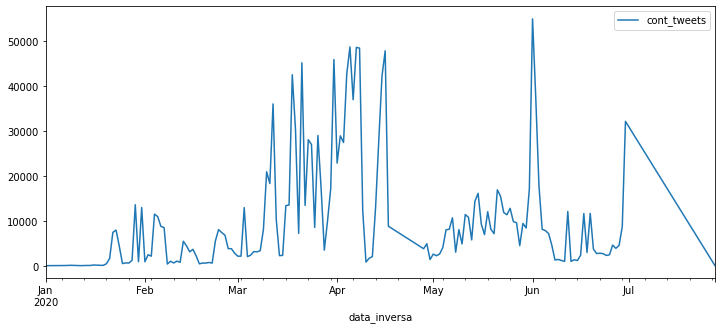

In [4]:
dados_sumario.plot(figsize=(12,5))

In [5]:
data.head(2)

,data,usuario,apelido,texto,retweet,seguidores,idioma,lugar,pais,sigla,latitude,longitude,hashtags
0,2020-03-23 18:51:14,Gaboardi,fraslee,@BolsonaroSP Cade o fundão deputado??? Congres...,0,138,pt,NaN,NaN,NaN,NaN,NaN,[]
1,2020-03-18 03:18:14,Seu Zé da Farmácia,seuzedafarmacia,"Em ação preventiva, o Governo do Estado suspen...",0,56,pt,NaN,NaN,NaN,NaN,NaN,[]


## 1.3 Rank de quantidade de Tweets por Cidade

* Selecionar as 10 primeiras cidades para exibição em um gráfico (dos tweets que possuiam essa informacao de local)

In [6]:
dados_cidades = data['lugar'].groupby(data['lugar']).agg('count').to_frame()
dados_cidades.columns = ['cont_tweets']

dados_cidades = dados_cidades.sort_values(['cont_tweets','lugar'], ascending=False)

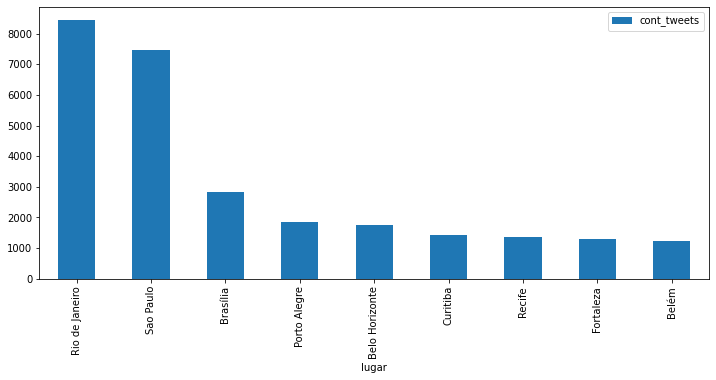

In [7]:
dados_cidades = dados_cidades[0:9]
dados_cidades.plot(kind= 'bar',figsize=(12,5))

## 1.4 Frequência dos Tweets por horas

In [8]:
df= data.copy()
df.index =  pd.to_datetime(df.data)
df = df.drop('data',axis=1)
df = df.sort_values(['data'])
hours = pd.Series(df.index.hour)
hours = pd.Series(hours.value_counts()).sort_index()

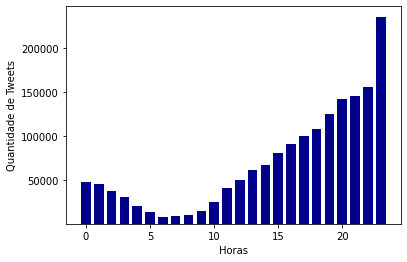

In [9]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

fig, ax = plt.subplots()
x = np.arange(len(hours))
y = np.array(hours)

dim = 1
w = 0.75
dimw = w / dim

for i in range(0,24):
  ax.bar(i,y[i],dimw,bottom=0.001,align='center',color='#00008B')
  
ax.set_xlabel('Horas')
ax.set_ylabel('Quantidade de Tweets')

plt.show()

## 1.5 Retweet por usuários que possuem maior numero de seguidores



> A relação do usuário com maior numero de seguidores e o usuário com maior numero de retweets não está coerente, seria efeito do bot ?



In [10]:
# Ranking dos usuários com maior numero de seguidores
rank = data.iloc[:,[1,4,5]]
rank = rank.groupby('usuario').agg(
    max_seguidores = pd.NamedAgg(column='seguidores',aggfunc=max),
    total_retweet = pd.NamedAgg(column='retweet',aggfunc=sum)
)
rank = rank.sort_values(by='max_seguidores',ascending=False)
#ranking dos usuarios com maior numero de retweets
rank2 = rank.sort_values(by='total_retweet',ascending=False)

In [11]:
print(rank[0:5])
print(rank2[0:5])

                 max_seguidores  total_retweet
usuario                                       
Donald J. Trump        84241250          21369
Reuters                22098307             46
CNN en Español         18878720            161
Danilo Gentili         17244348           1936
Whindersson 🏠          16969481          16886
                    max_seguidores  total_retweet
usuario                                          
Maryy                          218        1139763
My cabbages!!                  737         989485
Tr1gger Mike                    43         901093
🌹                             2513         887268
tweets not loading             765         850226


## 1.6 Total de Hashtags nas cidades mais frequentes

In [12]:
#1 = usuario | 7 = lugar | 12 = hashtags
rank = data.iloc[:,[1,7,12]]
rank.head(2)

# rank = rank.groupby('lugar').agg(
#     totalHashtags = pd.NamedAgg(column='hashtags',aggfunc=count)#,
#     #total_retweet = pd.NamedAgg(column='hashtags',aggfunc=sum)
# )
# rank #= rank.sort_values(by='max_seguidores',ascending=False)

test = rank.groupby(['lugar', 'usuario'])['hashtags'].count()
frame = pd.DataFrame(test)
frame = frame.sort_values('hashtags',ascending=False,ignore_index=False)
frame = frame.reset_index(level=[0])

frame[0:10]

,lugar,hashtags
usuario,,
TSF Rádio,Lisbon,338
Felipe 🅱️,Rio de Janeiro,205
Monster3366,Sao Paulo,156
Guto Menna-Barreto (em 🏚) 🏳️‍🌈,Curitiba,139
Ana Helena Mofatto 🇧🇷👊💚,Limeira,114
💙💛💚Débora.B.P.💚💛💙,Sao Paulo,96
Nelson Carvalheira,Rio de Janeiro,95
Lr1 | O Liberal Regional,Araçatuba,95
Emerson Damasceno,Fortaleza,82


In [13]:
popular_tweet_city = ['Rio de Janeiro','Sao Paulo','Brasília','Porto Alegre','Belo Horizonte']
total_hastags = []

for city in popular_tweet_city:
  uf = frame.loc[frame['lugar'] == city]
  uf = np.sum(uf['hashtags'])
  total_hastags.append(uf)

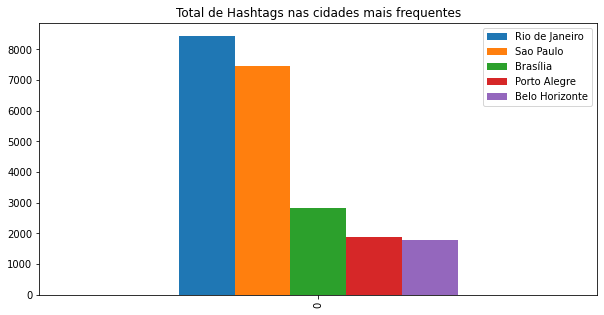

In [14]:
show = pd.DataFrame([total_hastags], columns=popular_tweet_city)
show.plot(kind= 'bar',figsize=(10,5),title='Total de Hashtags nas cidades mais frequentes')

# 2 Temas Discutidos

*   Identificar os Tweets que contenham perguntas ('?')
*   Após separar cada Tweet em sentenças, mantém-se apenas a setença que contenha '?'
  *  Remove os Links que foram identificados como possiveis perguntas (talvez contenham '?')
*   Remoção de StopWords



In [15]:
# Seleciona-se a coluna 'usuario' e 'texto'
dt_auxiliar = data.iloc[:,[1,3]]
dt_auxiliar.head(2)

,usuario,texto
0,Gaboardi,@BolsonaroSP Cade o fundão deputado??? Congres...
1,Seu Zé da Farmácia,"Em ação preventiva, o Governo do Estado suspen..."


In [16]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

stopwords = nltk.corpus.stopwords.words('portuguese')
sent_tokenizer=nltk.data.load('tokenizers/punkt/portuguese.pickle')

questions = list()

for i in range(0,dt_auxiliar.shape[0]):
  if dt_auxiliar.iloc[i].texto.find("?") >=0:
    sentences = sent_tokenizer.tokenize(dt_auxiliar.iloc[i].texto) #separando em sentenças
    if len(sentences) > 1:
      """ percorra o vetor das sentenças; identifique as perguntas; adicione a lista questions ( com a '?' )"""
      for i in range(0,len(sentences)):
        #se contem '?'
        if sentences[i].find("?") > -1: 
          """remova as stopwords da sentença"""    
          words_of_sentences = sentences[i].split()
          
          # se a palavra não for uma stopword
          see_stopwords = lambda word: True if word not in stopwords else False 
          result = " ".join( list(filter(see_stopwords, words_of_sentences)) )  # refazendo a string com as palavras resultantes do filtro
          
          # adicione o result a lista de questões
          questions.append(result)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [17]:
len(questions)
#questions

177347

In [18]:
from nltk import *

aux = " ".join(questions[0:10])
aux

# fdist = FreqDist(" ".join(questions))
# fdist

'@BolsonaroSP Cade fundão deputado??? Fumaça cigarro pode propagar coronavírus? @ipratesMD @dr_pampers Será corremos risco termos piolhos super resistentes? Prioridade ?! Que tal notícia boa, indo contramão mídia corrupta fazendo (tocando terror população)? @mitags Será Bolsonaro fez propaganda? #perguntacorona Quero saber covid cura? @elmundoes eres republicano? Quem Pandemia? Cadê polícia Dória prendia velhos, mulheres trabalhadores pandemia ???'

In [19]:
# import nltk
# nltk.download('stopwords')

# stopwords = nltk.corpus.stopwords.words('portuguese')
# frase= 'ele não foi ao centro comprar pão, pois ele e ela gostaram mais de ficar e comer um empanado'

# sentenca = frase.split()

# ver_stopwords = lambda word: True if word not in stopwords else False # se a palavra não for uma stopword
# result = " ".join(list(filter(ver_stopwords, sentenca)))  # refazendo a string com as palavras resultantes do filtro
# print(result)

In [20]:
nltk.FreqDist(

SyntaxError: ignored

In [ ]:
import re
# ENCONTRA E RETORNA AS POSIÇÕES DAS LETRAS DAS PALAVRAS
aux = re.search('levi', 'From leviHere to Eternity levi') 
aux.span()


* Limpeza

In [26]:
pln = spacy.load('pt')
stopwords = nltk.corpus.stopwords.words('portuguese')

def preprocess(texto):
  # Letras minúsculas
  texto = texto.lower()

  # Nome do usuário
  texto = re.sub(r"@[A-Za-z0-9$-_@.&+]+", ' ', texto)
  #texto = re.sub(r"@",'', texto)

  # URLs
  texto = re.sub(r"https?://[A-Za-z0-9./]+", ' ', texto)

  # Espaços em branco
  texto = re.sub(r":[A-Za-z0-9$-_@.&+]+",'', texto)
  texto = re.sub(r";[A-Za-z0-9$-_@.&+]+",'', texto)
  texto = re.sub(r" +",' ', texto)
  

  # Lematização
  documento = pln(texto)
  
  lista = []
  for token in documento:
    if str(token) not in stopwords:
      lista.append(token.lemma_)
    
  # Stop words e pontuações
  lista = [palavra for palavra in lista if palavra not in string.punctuation]
  lista = ' '.join([str(elemento) for elemento in lista if not elemento.isdigit()])
  
  return lista

result = map(preprocess,questions[0:2])
questions_cleaned = list(set(result))
print(questions_cleaned)

['  cade fundão deputar', 'fumaça cigarrar poder propagar coronavírus']


## 2.1 Doença

## 2.2 Medicamento

## 2.3 Organizações

## 2.4 Pessoas

# 3 Visões

## 3.1 Temporal

## 3.2 Geográfica

In [ ]:
# print(type(dados['texto']))

In [ ]:
# print(dados.count)

In [ ]:
# dados2 = dados.loc[dados.texto.str.find('?') >= 0 ]

In [ ]:
# print(dados2.count)

In [ ]:
# dados2.head(10)

Extrair as perguntas dos tweets que apresentam perguntas


In [ ]:
# print(dados2.dtypes)

In [ ]:
# # !pip install nltk

# import nltk

# from nltk import sent_tokenize

# nltk.download('punkt')

In [ ]:

#dados2['pergunta_extraida'] = sent_tokenize(dados2.texto.str)

#print(dados2.dtypes)

# print(type(dados2.texto.str.))

# 4 - Conclusões